# Data Analysis - Road Geometry

Purpose of this notebook: analyzing the distribution of missing geometry data in a large enough OSM map.

[Jump to Geometry Analysis](#geometry-analysis)

In [1]:
import route2vel
from route2vel.loading import *
from route2vel.route import *
from route2vel.extract import *
from notebookutils import *
import os, sys
import pandas as pd
import numpy as np
import osmnx
import math
import contextily as cx
from statistics import mean
from numpy.linalg import norm

C:\Users\fillo\AppData\Local\Temp\ipykernel_9676\3650653229.py:4: DeprecationWarning: the extract module is deprecated
  from route2vel.extract import *


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
graph_area = "Emilia-Romagna, Italy"

In [4]:
route2vel.load_config('../..')

In [5]:
import locale
locale.setlocale(locale.LC_ALL, '')

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors

# plt.style.use('dark_background')
plt.style.use('default')

In [6]:
route2vel.load_config("..", force=True)
cx.set_cache_dir(route2vel.cfg["resources_dir"] + "/contextily_cache")

In [7]:
graph_raw = load_graph(graph_area, cache_graph=True, fill_data=False, filename=f"{graph_area.split(',')[0].strip()}_RAW.graphml")

Loading graph from d:\Documenti\Universita\tesim\route2vel\resources\graph\Emilia-Romagna_RAW.graphml.graphnx.pickle ...
Loaded in 4.07s!


In [8]:
(points_gdf, edges_gdf) = osmnx.utils_graph.graph_to_gdfs(graph_raw, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=False)

In [9]:
points_gdf.head()

,y,x,street_count,highway,ref,geometry
osmid,,,,,,
82596478,43.799669,12.175156,2,NaN,NaN,POINT (12.17516 43.79967)
82596491,43.793097,12.166587,3,NaN,NaN,POINT (12.16659 43.79310)
82596497,43.789887,12.160022,3,NaN,NaN,POINT (12.16002 43.78989)
82596871,43.820093,12.248039,3,NaN,NaN,POINT (12.24804 43.82009)
82596874,43.818922,12.245215,3,NaN,NaN,POINT (12.24521 43.81892)


In [10]:
points_gdf.describe()

,y,x,street_count
count,202336.000000,202336.000000,202336.000000
mean,44.536445,11.199178,2.638137
std,0.297036,0.865572,0.908134
min,43.744214,9.217385,1.000000
25%,44.330603,10.564203,3.000000
50%,44.575367,11.158909,3.000000
75%,44.776198,11.955284,3.000000
max,45.128108,12.755707,8.000000


In [11]:
edges_gdf.head()

osmid  \
u        v          key                                    
82596478 926806953  0                           10052446   
82596491 2324314035 0                           27474209   
         926806953  0    [27474208, 27474209, 742213322]   
         2940404641 0                          114271122   
82596497 2507006493 0                          643536492   

                                                                      name  \
u        v          key                                                      
82596478 926806953  0                       Strada Provinciale Casteldelci   
82596491 2324314035 0                                   Località Pianerini   
         926806953  0    [Strada Provinciale Casteldelci, Località Pian...   
         2940404641 0                                                  NaN   
82596497 2507006493 0                                 Località Giardiniera   

                              highway  oneway reversed   length  \
u        v          key                                           
82596478 926806953  0        tertiary   False    False  572.859   
82596491 2324314035 0        tertiary   False    False   89.155   
         926806953  0        tertiary   False     True  589.962   
         2940404641 0    unclassified   False    False  515.236   
82596497 2507006493 0    unclassified   False     True   42.428   

                                                                  geometry  \
u        v          key                                                      
82596478 926806953  0    LINESTRING (12.17516 43.79967, 12.17425 43.799...   
82596491 2324314035 0    LINESTRING (12.16659 43.79310, 12.16637 43.792...   
         926806953  0    LINESTRING (12.16659 43.79310, 12.16675 43.793...   
         2940404641 0    LINESTRING (12.16659 43.79310, 12.16706 43.793...   
82596497 2507006493 0    LINESTRING (12.16002 43.78989, 12.15990 43.789...   

                        bridge  ref lanes junction maxspeed tunnel access  \
u        v          key                                                     
82596478 926806953  0      NaN  NaN   NaN      NaN      NaN    NaN    NaN   
82596491 2324314035 0      NaN  NaN   NaN      NaN      NaN    NaN    NaN   
         926806953  0      yes  NaN   NaN      NaN      NaN    NaN    NaN   
         2940404641 0      NaN  NaN   NaN      NaN      NaN    NaN    NaN   
82596497 2507006493 0      NaN  NaN   NaN      NaN      NaN    NaN    NaN   

                        width est_width area service  
u        v          key                               
82596478 926806953  0     NaN       NaN  NaN     NaN  
82596491 2324314035 0     NaN       NaN  NaN     NaN  
         926806953  0     NaN       NaN  NaN     NaN  
         2940404641 0     NaN       NaN  NaN     NaN  
82596497 2507006493 0     NaN       NaN  NaN     NaN

In [12]:
edges_gdf.describe()

,length
count,454680.000000
mean,216.932417
std,452.741726
min,0.105000
25%,39.451750
50%,82.326000
75%,188.047000
max,18859.183000


In [13]:
# ax = pd.concat([edges_gdf['geometry'], points_gdf['geometry']]).plot(figsize=(40, 20), edgecolor='k', alpha=0.25)
# cx.add_basemap(ax, crs=edges_gdf.crs)

## Geometry analysis

First question: how many edges have undefined geometry?

In [14]:
print(f"Edges with missing geometry: {100 - edges_gdf['geometry'].count() * 100 / len(edges_gdf):5.2f}% ({edges_gdf['geometry'].count():n}/{len(edges_gdf):n})")

Edges with missing geometry: 34.39% (298.295/454.680)


### Road types in missing geometry

By road type:


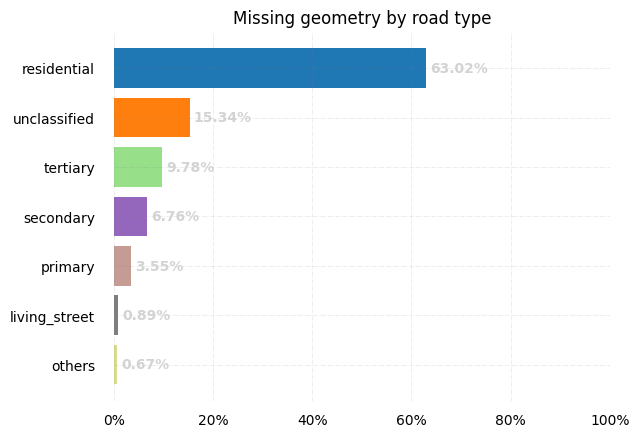

,count
highway,
primary_link,0.125%
tertiary_link,0.098%
trunk_link,0.083%
road,0.083%
trunk,0.080%
motorway,0.072%
secondary_link,0.070%
motorway_link,0.038%
rest_area,0.009%


In [15]:
print("By road type:")

no_geom_edges_gdf: pd.DataFrame = edges_gdf[edges_gdf['geometry'].isna()]
# ax = pd.DataFrame(no_geom_edges_gdf['highway'].value_counts().apply(lambda x: x * 100 / len(no_geom_edges_gdf))).plot.bar(colormap='Paired')
vals = no_geom_edges_gdf['highway'].value_counts().apply(lambda x: x * 100 / len(no_geom_edges_gdf))
vals2 = vals.copy()
treshold = 0.5
vals['others'] = vals[vals < treshold].sum()
vals.drop(labels=vals[vals < treshold].index.drop('others', errors='ignore'), inplace=True)

fig, ax = plt.subplots()

make_better_barh(ax, vals.index, vals, title="Missing geometry by road type", cmap='tab20', pct=True)

plt.show()

pd.DataFrame(vals2[vals2 < treshold].apply(lambda x: f"{x:6.3f}%"))

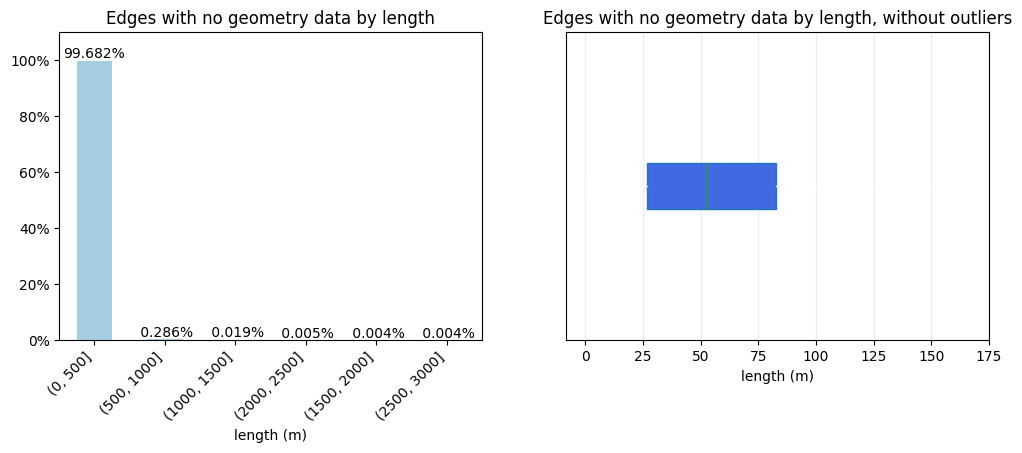

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# By length
x_max = math.ceil(no_geom_edges_gdf['length'].max() / 500) * 500
nbins = 6 if x_max % 6 == 0 else 5
ax = (pd.cut(no_geom_edges_gdf['length'], bins=pd.interval_range(start=0, periods=nbins, end=x_max)).value_counts()
        .apply(lambda x: x * 100 / len(no_geom_edges_gdf))
        .plot.bar(title="Edges with no geometry data by length", cmap='Paired', ax = axes[0])
    )

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylim([0, 110])
ax.set_xlabel('length (m)')
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')

for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{height:6.3f}%', (x + width/2, y + height + 1), ha='center')

ax2, boxplot = no_geom_edges_gdf.boxplot(
    'length', ax = axes[1], 
    return_type='both',
    vert=False,
    showfliers=False,
    patch_artist=True,  # fill with color
)
ax2.set_title("Edges with no geometry data by length, without outliers")
ax2.grid(alpha=0.25)
ax2.grid(False, axis='y')
ax2.set_xlabel("length (m)")
ax2.set_yticks([])

for box in boxplot['boxes']:
    box.set_facecolor('royalblue')
for patch in boxplot['whiskers']:
    patch.set_color('white')
for patch in boxplot['caps']:
    patch.set_color('white')

Judging from the box plot, the majority (>75%) of the edges with missing geometry are shorter than 100m, and most are residential roads, so it can be assumed that they are straight lines.

### Missing geometry in road types

And now, we'll check the inverse data: of each category (length interval, road type), how many edges do not have geometry data.

Check how many edges in each data type have missing geometry:

Missing geometry in road types:


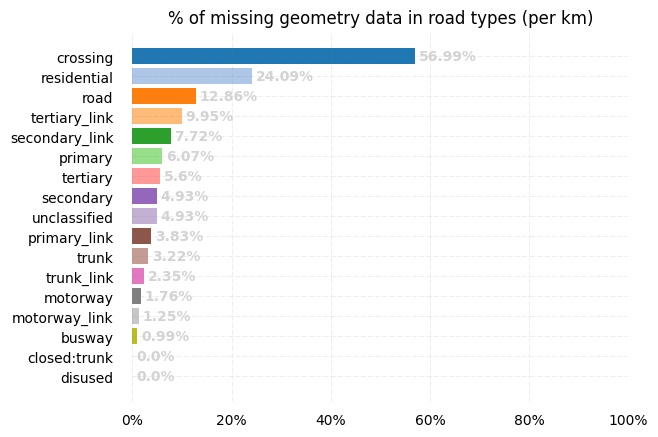

,pct,len_pct,null,total,len_median
highway,,,,,
crossing,75.00%,56.99%,6,8,4.3
residential,44.74%,24.09%,98548,220257,57.5
road,41.94%,12.86%,130,310,42.9
tertiary_link,21.10%,9.95%,154,730,19.5
secondary_link,18.18%,7.72%,110,605,19.3
primary,25.44%,6.07%,5548,21805,31.1
tertiary,26.77%,5.60%,15301,57157,34.4
secondary,23.93%,4.93%,10566,44150,29.3
unclassified,23.21%,4.93%,23982,103342,52.7


In [17]:
print("Missing geometry in road types:")

by_road_missing_df: pd.DataFrame = edges_gdf.explode('highway').groupby('highway').agg(
    pct=('geometry', lambda x: x.isnull().sum() * 100 / len(x)), 
    len_pct=('length', lambda x: x[edges_gdf['geometry'].isnull()].sum() / x.sum() * 100),
    null=('geometry', lambda x: x.isnull().sum()), 
    total=('geometry', len),
    len_median=('length', lambda x: round(x[edges_gdf['geometry'].isnull()].median(), 1)),
    )\
    .sort_values(by='len_pct', ascending=False)

fig, ax = plt.subplots()

non_drive_rtpes = ['living_street', 'rest_area', 'emergency_bay']

by_road_missing_df = by_road_missing_df.drop(non_drive_rtpes)

make_better_barh(ax, by_road_missing_df.index, by_road_missing_df['len_pct'], title="% of missing geometry data in road types (per km)", cmap='tab20', pct=True)

plt.show()

by_road_missing_df['pct'] = by_road_missing_df['pct'].apply(lambda x: f'{x:5.2f}%')
by_road_missing_df['len_pct'] = by_road_missing_df['len_pct'].apply(lambda x: f'{x:5.2f}%')
by_road_missing_df

Check how many edges of each length category have missing geometry, dividing in intervals such that the amount of total nodes of that category are the same.

C:\Users\fillo\AppData\Local\Temp\ipykernel_9676\1193337517.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_length_geom_df = length_geom_df[['category', 'geometry']].groupby('category').agg(


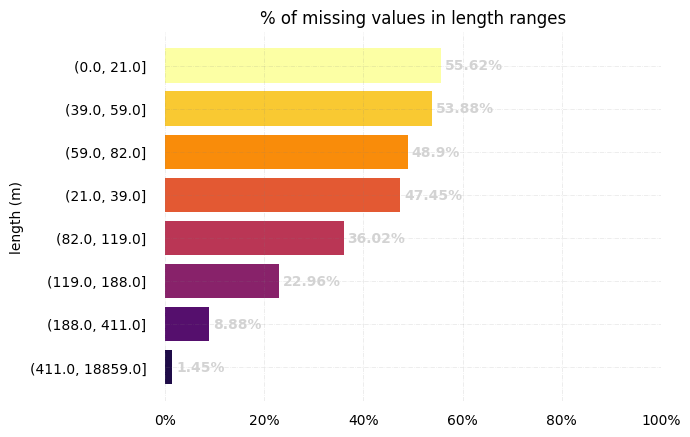

In [18]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# By length
length_geom_df: pd.DataFrame = edges_gdf[['length', 'geometry']]

length_geom_df = length_geom_df.assign(
    category = pd.qcut(length_geom_df['length'], q=8)\
        .apply(lambda x: pd.Interval(left=int(x.left), right=int(x.right))),
)
grouped_length_geom_df = length_geom_df[['category', 'geometry']].groupby('category').agg(
    pct=('geometry', lambda x: x.isnull().sum() * 100 / len(x))
).sort_values(by='pct', ascending=False) \

fig, ax = plt.subplots()

make_better_barh(ax, grouped_length_geom_df.index.map(lambda x: str(x)), grouped_length_geom_df['pct'], 
                 cmap='inferno_r', pct=True,
                 title="% of missing values in length ranges"
                 )

ax.set_ylabel("length (m)")

plt.show()

C:\Users\fillo\AppData\Local\Temp\ipykernel_9676\1193337517.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_length_geom_df = length_geom_df[['category', 'geometry']].groupby('category').agg(


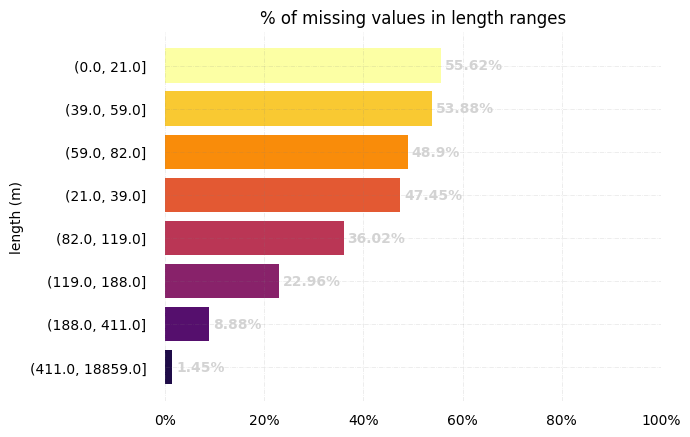

In [19]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# By length
length_geom_df: pd.DataFrame = edges_gdf[['length', 'geometry']]

length_geom_df = length_geom_df.assign(
    category = pd.qcut(length_geom_df['length'], q=8)\
        .apply(lambda x: pd.Interval(left=int(x.left), right=int(x.right))),
)
grouped_length_geom_df = length_geom_df[['category', 'geometry']].groupby('category').agg(
    pct=('geometry', lambda x: x.isnull().sum() * 100 / len(x))
).sort_values(by='pct', ascending=False) \

fig, ax = plt.subplots()

make_better_barh(ax, grouped_length_geom_df.index.map(lambda x: str(x)), grouped_length_geom_df['pct'], 
                 cmap='inferno_r', pct=True,
                 title="% of missing values in length ranges"
                 )

ax.set_ylabel("length (m)")

plt.show()

## Long roads with missing geometry

As [above](#road-types-in-missing-geometry), there are not many but still some roads that are long without geometry data. We'll check which ones they are:

Amount of edges with no geometry above 100m: 27503
Amount of edges with no geometry above 500m: 497
Amount of edges with no geometry above 1000m: 50


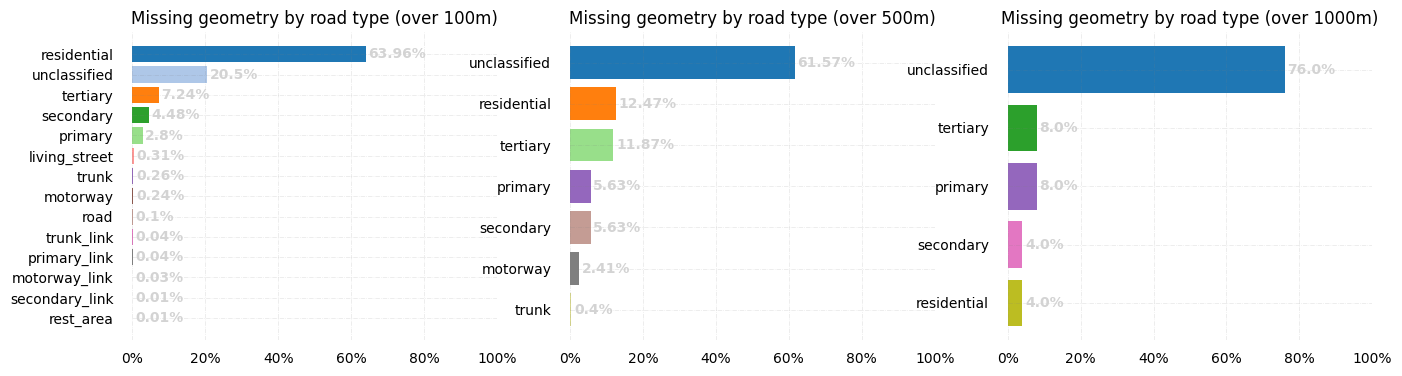

In [20]:
no_geom_edges_gdf: pd.DataFrame = edges_gdf[edges_gdf['geometry'].isna()]
tresholds = [100, 500, 1000]

fig, axes = plt.subplots(ncols = len(tresholds), figsize=(16, 4))
for (i, treshold), ax in zip(enumerate(tresholds), axes):
    filtered_gdf = no_geom_edges_gdf[no_geom_edges_gdf['length'] > treshold]

    vals = filtered_gdf['highway'].value_counts().apply(lambda x: x * 100 / len(filtered_gdf))

    make_better_barh(ax, vals.index, vals, title=f"Missing geometry by road type (over {treshold}m)", cmap='tab20', pct=True)

    print(f"Amount of edges with no geometry above {treshold}m: {len(filtered_gdf)}")

plt.show()

The edges above 1km are worrying: checking in more detail:

In [21]:
long_roads_no_geom_data = no_geom_edges_gdf[no_geom_edges_gdf['length'] > 1000].dropna(axis=1, how='all').sort_values(by='length', ascending=False)
# names only, for checking on map services
long_roads_no_geom_data.groupby(['name', 'ref'], dropna=False).agg(
    length = ('length', 'sum'),
).sort_values(by='length', ascending=False)

,,length
name,ref,
NaN,NaN,14507.442
Strada Fiume,SP78,5720.920
Strada Trieste,NaN,5720.078
Strada Umana,NaN,5661.712
Strada Buie d'Istria,NaN,4925.372
Strada Alberelli,NaN,4030.452
Strada Pola,NaN,4028.420
Strada dei Fiocinini,NaN,3238.314
Strada Corletto Sud,NaN,3022.216


Most missing roads are countryside roads, but there are 14km of unknown roads plus some kms of primary and secondary streets. In more detail:

In [22]:
# details
long_roads_no_geom_data

,,,osmid,name,highway,oneway,reversed,length,ref,lanes,maxspeed
u,v,key,,,,,,,,,
1411326890,1411326892,0,127544826,Strada Fiume,tertiary,False,True,2860.460,SP78,NaN,NaN
1411326892,1411326890,0,127544826,Strada Fiume,tertiary,False,False,2860.460,SP78,NaN,NaN
276117158,472398280,0,27242061,Strada Trieste,unclassified,False,True,2860.039,NaN,NaN,NaN
472398280,276117158,0,27242061,Strada Trieste,unclassified,False,False,2860.039,NaN,NaN,NaN
1203420004,1262044000,0,269815851,Strada Umana,unclassified,False,True,2830.856,NaN,NaN,NaN
1262044000,1203420004,0,269815851,Strada Umana,unclassified,False,False,2830.856,NaN,NaN,NaN
473088496,473088498,0,39493521,Strada Buie d'Istria,unclassified,False,True,2462.686,NaN,NaN,NaN
473088498,473088496,0,39493521,Strada Buie d'Istria,unclassified,False,False,2462.686,NaN,NaN,NaN
1203422376,1203420808,0,104296418,NaN,unclassified,False,True,2015.382,NaN,NaN,NaN


To assess the importance (or lack thereof) of the missing data, let's display the nodes related to these roads:

In [23]:
def get_points(gdf):
    return pd.concat(
        [gdf.index.get_level_values(0).to_series(), gdf.index.get_level_values(1).to_series()],
        ignore_index=True,
    ).drop_duplicates()

point_ids = get_points(long_roads_no_geom_data)

# ax = points_gdf.loc[point_ids, :].plot(figsize=(40, 20), edgecolor="k")
# cx.add_basemap(ax, crs=points_gdf.loc[point_ids, :].crs)
# plt.title("Points of long edges with no geometry data");

In [24]:
# point_ids = get_points(long_roads_no_geom_data[long_roads_no_geom_data['name'].isna()])
# ax = points_gdf.loc[point_ids, :].plot(figsize=(40, 20), edgecolor="k")
# cx.add_basemap(ax, crs=points_gdf.crs)
# plt.title("Points of long edges with no geometry data and road name");

## Point distance analysis

Check how dense the geometry data points are, considering only edges with geometry set.

In [25]:
nn_geom_gdf: gpd.GeoDataFrame = edges_gdf.loc[edges_gdf['geometry'].notnull(), :]

def avg_dist(l: LineString):
    carr = np.array(l.coords)
    return mean(np.linalg.norm(carr[1:] - carr[:-1], axis=1))

nn_geom_gdf['avg_dist_c'] = nn_geom_gdf.loc[:, 'geometry'].apply(avg_dist)
nn_geom_gdf['avg_dist'] = nn_geom_gdf['avg_dist_c'] * nn_geom_gdf['length'] / nn_geom_gdf['geometry'].apply(lambda l: l.length)


d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
d:\Documenti\Universita\tesim\route2vel\.venv\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
nn_geom_gdf.describe()

,length,avg_dist_c,avg_dist
count,298295.000000,298295.000000,298295.000000
mean,296.081460,0.000390,35.926906
std,540.040708,0.000447,40.629130
min,1.306000,0.000006,0.638500
25%,54.061000,0.000149,13.804258
50%,122.110000,0.000266,24.697500
75%,293.997500,0.000470,43.389667
max,18859.183000,0.021639,2220.778000


C:\Users\fillo\AppData\Local\Temp\ipykernel_9676\1919122518.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = pd.DataFrame(nn_geom_gdf.groupby(simplified_cut)['avg_dist'].mean()).fillna(0)


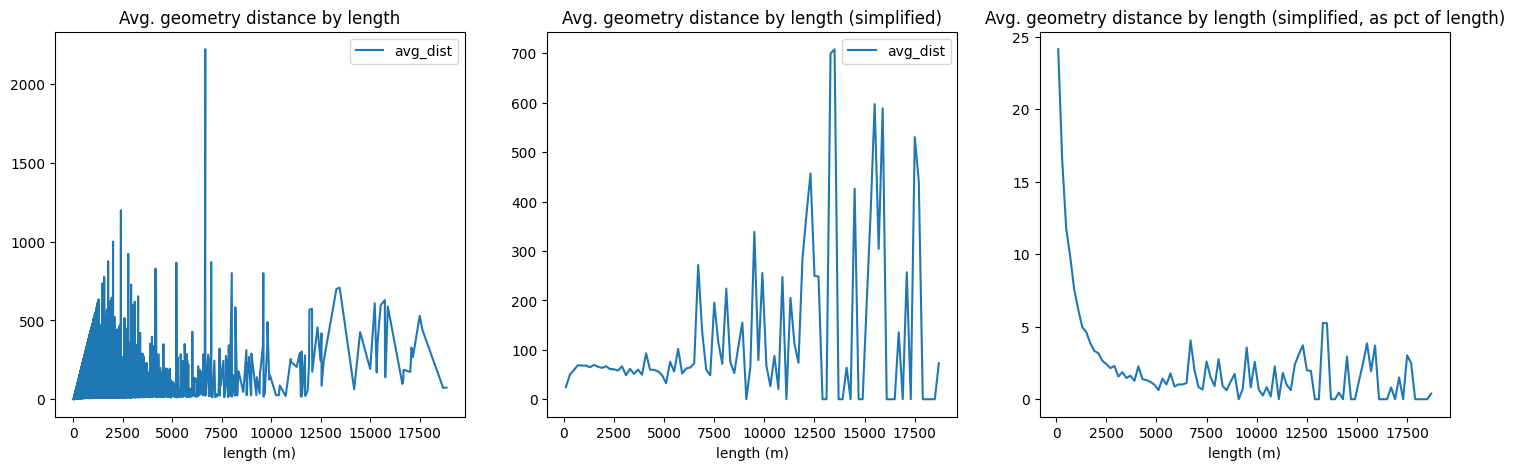

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

simplified_cut = pd.cut(nn_geom_gdf['length'], pd.interval_range(start=nn_geom_gdf['length'].min(), end=nn_geom_gdf['length'].max(), freq=200))
grouped = pd.DataFrame(nn_geom_gdf.groupby(simplified_cut)['avg_dist'].mean()).fillna(0)
grouped['x'] = pd.Series(grouped.index.to_series().apply(lambda x: (x.left + x.right) / 2).to_list(), index = grouped.index)

nn_geom_gdf.sort_values(by='length').plot.line(x='length', y='avg_dist', title='Avg. geometry distance by length', ax=axes[0])
grouped.plot.line(x='x', y='avg_dist', title='Avg. geometry distance by length (simplified)', ax=axes[1])
axes[2].plot(grouped['x'], grouped['avg_dist'] * 100 / grouped['x'])
axes[2].set_title('Avg. geometry distance by length (simplified, as pct of length)')

axes[0].set_xlabel('length (m)')
axes[1].set_xlabel('length (m)')
axes[2].set_xlabel('length (m)');

C:\Users\fillo\AppData\Local\Temp\ipykernel_9676\3503373697.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = df[['category', 'avg_dist']].groupby('category').agg(


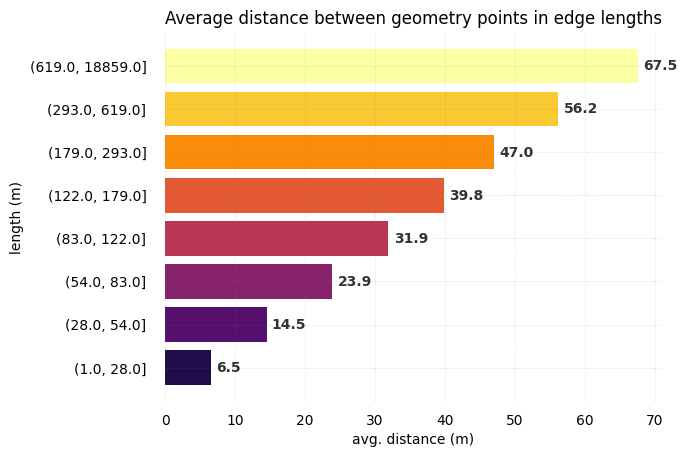

In [28]:
# By length
df: pd.DataFrame = nn_geom_gdf[['length', 'avg_dist']]

df = df.assign(
    category = pd.qcut(df['length'], q=8)\
        .apply(lambda x: pd.Interval(left=int(x.left), right=int(x.right))),
)
grouped_df = df[['category', 'avg_dist']].groupby('category').agg(
    avg_dist=('avg_dist', lambda x: round(x.mean(), 1))
).sort_values(by='category', ascending=False) \

fig, ax = plt.subplots()

make_better_barh(ax, grouped_df.index.map(lambda x: str(x)), grouped_df['avg_dist'], 
                 cmap='inferno_r',
                 title="Average distance between geometry points in edge lengths",
                 numcolor='#333333'
                 )

ax.set_ylabel("length (m)")
ax.set_xlabel("avg. distance (m)")

plt.show()

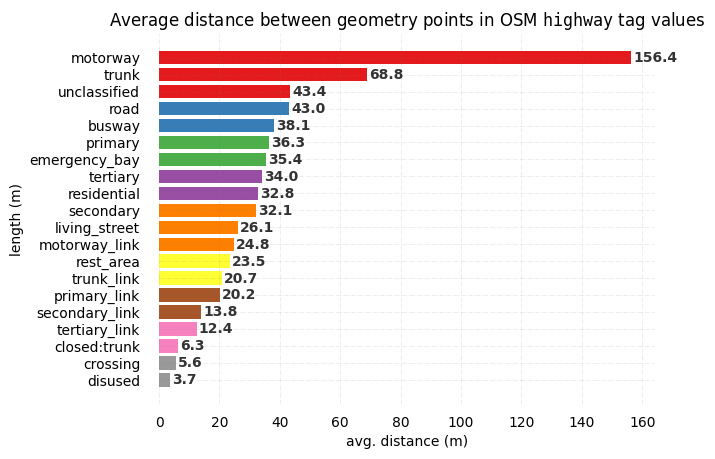

In [39]:
# By length
df: pd.DataFrame = nn_geom_gdf[['highway', 'avg_dist']]

grouped_df = df.explode("highway").groupby('highway').agg(
    avg_dist=('avg_dist', lambda x: round(x.mean(), 1))
).sort_values(by='avg_dist', ascending=False) \

fig, ax = plt.subplots()

make_better_barh(ax, grouped_df.index.map(lambda x: str(x)), grouped_df['avg_dist'], 
                 cmap='Set1',
                 title="Average distance between geometry points in OSM $\\mathtt{highway}$ tag values",
                 numcolor='#333333'
                 )

ax.set_ylabel("length (m)")
ax.set_xlabel("avg. distance (m)")

plt.show()